In [4]:
import os
import json
import numpy as np

import torch
import torch.nn as nn
from torch.optim import AdamW
import cv2
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
import torchvision
from torchvision.transforms import transforms

In [26]:
save_dir = r"C:\Users\dra04\OneDrive - 경희대학교\바탕 화면\test\json"
image_dir = r"C:\Users\dra04\OneDrive - 경희대학교\바탕 화면\test\picture"

json_files = []
image_files=[]
for file in os.listdir(save_dir):
    json_files.append(os.path.join(save_dir, file))
    image_files.append(os.path.join(image_dir,file))

print("데이터 개수:", len(json_files))
print("이미지 개수:", len(image_files))

데이터 개수: 35
이미지 개수: 35


In [27]:
clothes_class = ["아우터", "하의", "원피스", "상의"]
clothes_xy = {"outer_xy":None, "pants_xy":None, "onepiece_xy":None, "shirt_xy":None}
clothes_fabric = {"outer_fabric":None, "pants_fabric":None, "onepiece_fabric":None, "shirt_fabric":None}

image_dict = {}

for file in json_files:
    with open(file, "rb") as f:
        data = json.load(f)
        file_name = data['이미지 정보']['이미지 파일명']
        for cls, xy, fabric in zip(clothes_class, clothes_xy, clothes_fabric):
            clothes_xy[xy] = data['데이터셋 정보']['데이터셋 상세설명']['렉트좌표'][cls][0].values()
            if not clothes_xy[xy]:
                continue
            try:
                clothes_fabric[fabric] = data['데이터셋 정보']['데이터셋 상세설명']['라벨링'][cls][0]['소재']
            except:
                print(file_name)
                print("--------------------")
        # print(clothes_xy)
        # print(clothes_fabric)

    for xy, fabric in zip(clothes_xy.values(), clothes_fabric.values()):
        if not xy:
            continue
        image_dict[(file_name, xy)] = fabric

image_dict

1 (30120).jpg
--------------------
@기획샘플@-ops4537k04(2)-바이보늬(샘플,주름멜빵)-얼굴컷,어두운거는 밝게 보정해주시고 치마가 예쁘게 나온걸로 사진 많이 넣어주세여~-IMG_E0624.JPG
--------------------


{('(121)IMG_1.jpg', dict_values([74.5, 538.098, 485, 324])): ['우븐'],
 ('(131)IMG_1.jpg', dict_values([192.5, 448.731, 303, 323])): ['니트'],
 ('(131)IMG_1.jpg', dict_values([231.5, 467.724, 225, 450])): ['우븐'],
 ('(141)IMG_1.jpg', dict_values([192.5, 470.5, 328, 319])): ['니트'],
 ('(141)IMG_1.jpg', dict_values([241.5, 520.5, 285, 537])): ['우븐'],
 ('(151)IMG_1.jpg', dict_values([202.5, 68.5, 416, 476])): ['트위드'],
 ('(151)IMG_1.jpg', dict_values([265.5, 73.5, 252, 525])): ['우븐'],
 ('(19)IMG_1.jpg', dict_values([291.5, 530.701, 163, 298])): ['벨벳'],
 ('(19)IMG_1.jpg', dict_values([298.5, 411.345, 161, 158])): ['저지'],
 ('(191)IMG_1.jpg', dict_values([256.5, 575.5, 298, 403])): ['우븐'],
 ('(201)IMG_1.jpg', dict_values([332.5, 674.5, 127, 300])): ['우븐'],
 ('(201)IMG_1.jpg', dict_values([307.5, 518.5, 160, 213])): ['우븐'],
 ('(211)IMG_1.jpg', dict_values([205.5, 420.5, 343, 399])): ['시폰'],
 ('(356)IMG_1.jpg', dict_values([263.5, 613.5, 143, 361])): ['데님'],
 ('(356)IMG_1.jpg', dict_values([248.5, 43

In [28]:
class ClothDataset(Dataset):
    def __init__(self, image_dict, data_dir=r"C:\Users\dra04\OneDrive - 경희대학교\바탕 화면\test\원천데이터"): #picture
        super().__init__()
        self.data_dir = data_dir
        self.image_dict = image_dict
        self.image_files = []
        self.dict_label_to_num = {
            "퍼" : 0,
            "니트" : 1,
            "무스탕" : 2,
            "레이스" : 3,
            "스웨이드" : 4,
            "린넨" : 5,
            "앙고라" : 6,
            "메시" : 7,
            "코듀로이" : 8,
            "플리스" : 9,
            "시퀸/글리터" : 10,
            "네오프렌" : 11,
            "데님" : 12,
            "실크" : 13,
            "저지" : 14,
            "스판덱스" : 15,
            "트위드" : 16,
            "자카드" : 17,
            "벨벳" : 18,
            "가죽" : 19,
            "비닐/PVC" : 20,
            "면" : 21,
            "울/캐시미어" : 22,
            "시폰" : 23,
            "합성섬유" : 24,
            "우븐" : 25
        }
        self.setup()

    def setup(self):
        for (file_name, xy), fabric in self.image_dict.items():
            if not fabric:
                continue
            self.image_files.append((os.path.join(self.data_dir, file_name), xy, fabric))

    def __getitem__(self, idx):
        file_name, xy, fabric = self.image_files[idx]
        fabric=fabric[0]
        x, y, w, h = map(int, xy)
        im = Image.open(file_name)
        im = transforms.ToTensor()(im)
        im = torchvision.transforms.functional.crop(im, y, x, h, w)
        im = transforms.Resize((300,300))(im)

        fabric_label = self.dict_label_to_num[fabric]
        return im, fabric_label
    
    def __len__(self):
        return len(self.image_files)



In [29]:
class ClothModel(nn.Module):
    def __init_(self, num_classes=26):
        super().__init__()
        self.model = resnet18(pretrained=True)
        self.fc =  nn.Linear(1000, num_classes)

    def forward(self,x):
        x = self.model(x)
        return self.fc(x)

In [30]:
dataset = ClothDataset(image_dict)
print(len(dataset))

57


In [34]:
BATCH_SIZE = 16
EPOCHS =5
LOG_INTERVAL=100
LEARNING_RATE=0.001
SAVE_DIR="./results"

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

loader=DataLoader(dataset, batch_size=BATCH_SIZE, drop_last=True,shuffle=True)

model=ClothModel()
model.to(device)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

#criterion=nn.CrossEntropyLoss()
#opt_module = getattr(import_module("torch.optim"), args.optimizer)  # optimizer 정의 - default: SGD
#optimizer = opt_module(
#    filter(lambda p: p.requires_grad, model.parameters()),
#    lr=args.lr,
#    weight_decay=5e-4
#)
#scheduler = StepLR(optimizer, args.lr_decay_step, gamma=0.5)
optim = AdamW(model.parameters(), lr=LEARNING_RATE)



for epoch in range(EPOCHS):
    model.train()
    loss_value=0
    matches=0
    for idx, batch in enumerate(tqdm(loader)): #train_loader
        inputs, labels=batch
        inputs=inputs.to(device)

        labels=labels.to(device)

        optim.zero_grad()

        outs=model(inputs)
        preds=torch.argmax(outs,dim=-1)
        loss=criterion(outs, labels)

        loss.backward()
        optim.step()

        loss_value += loss.item()
        matches += (preds==labels).sum().item()
        if(idx+1) % LOG_INTERVAL==0:
            train_loss=loss_value / LOG_INTERVAL
            train_acc=matches / BATCH_SIZE / LOG_INTERVAL
            print(
                f"Epoch[{epoch}/{EPOCHS}]({idx + 1}/{len(loader)}) || " #train_loader
                f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%}"
            )
            loss_value = 0
            matches = 0
    #        
    #with torch.no_grad():
    #    model.eval()
    #    val_loss_items=[]
    #    val_acc_items=[]
#
    #    for val_batch in val_loader:
    #        inputs, labels=val_batch
    #        inputs=inputs.to(device)
    #        labels=labels.to(device)
#
    #        outs=model(inputs)
    #        preds=torch.argmax(outs, dim=-1)
#
    #        loss_item = criterion(outs, labels).item()
    #        acc_item = (labels == preds).sum().item()
    #        val_loss_items.append(loss_item)
    #        val_acc_items.append(acc_item)
#
    #    val_loss=np.sum(val_loss_items) / len(val_loader)
    #    val_acc = np.sum(val_acc_items) / len(valid_dataset)
    #    best_val_loss = min(best_val_loss, val_loss)
    #    
    #    if val_acc > best_val_acc:
    #        print(f"New best model for val accuracy : {val_acc:4.2%}! saving the best model..")
    #        torch.save(model.module.state_dict(), f"{SAVE_DIR}/best.pth")
    #        best_val_acc = val_acc
    #    
    #    torch.save(model.module.state_dict(),f"{SAVE_DIR}/last.pth")
    #    print(
    #        f"[Val] acc : {val_acc:4.2%}, loss: {val_loss:4.2} || "
    #        f"best acc : {best_val_acc:4.2%}, best loss: {best_val_loss:4.2}"
    #    )
    #    print()
    #    
    #    
    

ValueError: optimizer got an empty parameter list

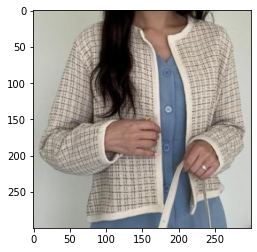

In [32]:
plt.imshow(dataset[3][0].permute(1, 2, 0))
